# Covariance Matrix

_UNDER CONSTRUCTION_

- Covariance Matrix Estimation: PCA, SVD, Shrinkage
- TODO: Risk Decomposition, Black-Litterman


In [1]:

from typing import Tuple
import numpy as np
from numpy.linalg import inv, svd
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import pandas as pd
from pandas import DataFrame, Series
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, EmpiricalCovariance
from finds.database import SQL, RedisDB
from finds.structured import CRSP
from finds.readers import FFReader
from finds.busday import BusDay
from finds.finance import halflife
from finds.plots import plot_bar
from finds.misc import Show
from secret import credentials, paths

In [2]:
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)
imgdir = paths['images']
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)

In [3]:
## Retrieve industry returns from Ken French Data Library website
name, item, suffix = ('49_Industry_Portfolios', 0, '49vw')
df = FFReader.fetch(name=name,
                    item=item,
                    suffix=suffix,
                    date_formatter=bd.endmo)

/home/terence/Dropbox/github/data-science-notebooks/finds/readers/ffreader.py:151: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pdr.data.DataReader(name=name,
/home/terence/Dropbox/github/data-science-notebooks/finds/readers/ffreader.py:151: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pdr.data.DataReader(name=name,
/home/terence/Dropbox/github/data-science-notebooks/finds/readers/ffreader.py:151: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pdr.data.DataReader(name=name,
/home/terence/Dropbox/github/data-scienc

In [4]:
# show missing dates
nans = df.isnull()
missing = {col: {'first': min(nans[nans[col]].index),
                 'last': max(nans[nans[col]].index),
                  'missing': np.sum(nans[col])}
           for col in df if nans[col].sum()}
df = df[df.index > 19690630]
Y = df.to_numpy()
show(DataFrame.from_dict(missing, orient='index'),
     latex=False,
     caption="Missing Values in FF-49 Industry Monthly Returns")

,first,last,missing
Missing Values in FF-49 Industry Monthly Returns,,,
Soda49vw,19260731,19630628,444
Hlth49vw,19260731,19690630,516
Rubbr49vw,19260731,19440630,60
FabPr49vw,19260731,19630628,444
Guns49vw,19260731,19630628,444
Gold49vw,19260731,19630628,444
PerSv49vw,19260731,19270630,12
Softw49vw,19260731,19650630,468
Paper49vw,19260731,19290629,36


## PCA and scree plot

In [5]:
# PCA of returns covariances by SVD
# SVD: u S vT = x (T samples x N stocks)
means = Y.mean(axis=0, keepdims=True)
X = Y.copy()

In [6]:
x = np.array(X - means) # pre-process: demean by column
u, s, vT = np.linalg.svd(x, full_matrices=False)
v = vT.T
k = 10
print(np.cumsum(s[:k]**2/np.sum(np.diag(s**2))))
print('u:', u.shape, 's:', s.shape, 'vT:', vT.shape, 'v', v.shape)

[0.56081683 0.62434391 0.66423103 0.70158944 0.73044243 0.75277385
 0.77084836 0.78503209 0.79886157 0.81079137]
u: (648, 49) s: (49,) vT: (49, 49) v (49, 49)


In [7]:
# sklearn PCA: X (T samples x N features/stocks), sanity check same results
pca = PCA()               # note: PCA first demeans input X by column mean_
y = pca.fit_transform(X)  # project X (stock returns) onto the components
print(pca.explained_variance_ratio_[:k])
print('y:', y.shape, 'x:', x.shape, 'components_:', pca.components_.shape)

[0.56081683 0.06352708 0.03988711 0.03735841 0.02885299 0.02233142
 0.01807451 0.01418374 0.01382948 0.01192979]
y: (648, 49) x: (648, 49) components_: (49, 49)


In [8]:
# assert: s == singular_values_ (aka 2-norm of the projection on components)
print('singular values:', np.allclose(pca.singular_values_, s))

singular values: True


In [9]:
# assert: s**2 / len(y) == explained_variance_
print('singular values:', np.allclose(pca.singular_values_, s))

singular values: True


In [10]:
# assert: x @ v == transform(x) (aka projection on components) (aka returns)
print('projections:', [np.allclose((x @ v)[:,i], -y[:,i]) or
                       np.allclose((x @ v)[:,i], y[:,i]) for i in range(k)])

projections: [True, True, True, True, True, True, True, True, True, True]


In [11]:
# assert: u @ s == transform(x) (aka factor returns)
print('projections:', [np.allclose(u[:,i]*s[i], -y[:,i]) or
                       np.allclose(u[:,i]*s[i], y[:,i]) for i in range(k)])

projections: [True, True, True, True, True, True, True, True, True, True]


In [12]:
# assert: cols of v == rows of components_ (right SVD eigenvectors) (weights)
print('components:', [np.allclose(pca.components_[i,:], -v[:,i]) or
                      np.allclose(pca.components_[i,:], v[:,i])
                      for i in range(k)])

components: [True, True, True, True, True, True, True, True, True, True]


In [13]:
# assert: covariance matrix == loadings.T @ loadings
loadings = np.diag(pca.singular_values_) @ pca.components_
print('covariance matrix:', np.allclose(x.T @ x, loadings.T @ loadings))

covariance matrix: True


In [14]:
### Projection on first component, and average "market" factor
t = pca.components_
top_k = 4
DataFrame({'frac weights +ve': np.mean(t[:top_k, :] >= 0, axis=1),
           'sum weights': np.sum(t[:top_k, :], axis=1),
           'sum abs weights': np.sum(np.abs(t[:top_k, :]), axis=1),
           'corr with eql-wtd market returns':
           [np.corrcoef(x.mean(axis=1), y[:,i])[0,1]
                        for i in range(top_k)]},
          index=[f"PC{i+1}" for i in range(top_k)])

,frac weights +ve,sum weights,sum abs weights,corr with eql-wtd market returns
PC1,0.000000,-6.836258,6.836258,-0.998857
PC2,0.244898,0.085580,4.141710,0.004209
PC3,0.428571,0.159702,3.708582,0.006223
PC4,0.326531,-0.972123,5.289028,-0.036660


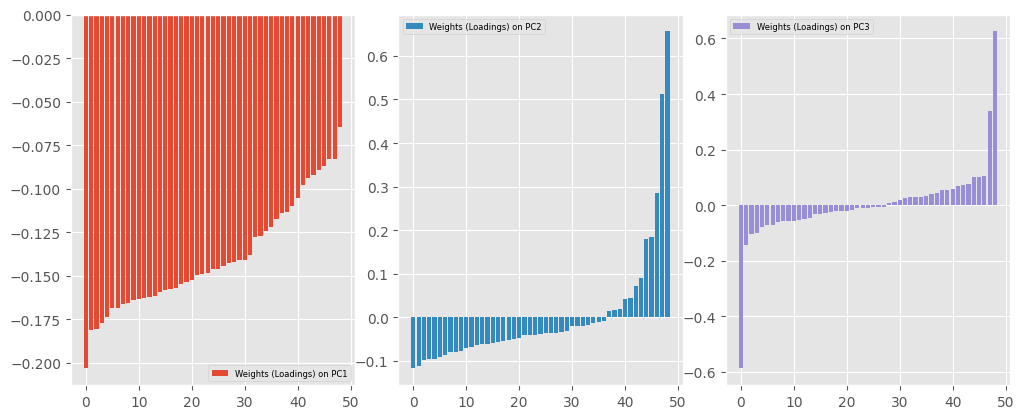

In [15]:
### Plot components/portfolio weights distribution 
fig, axes = plt.subplots(nrows=1, ncols=3, num=1, clear=True, figsize=(10, 4))
for i, ax in enumerate(np.ravel(axes)):
    ax.bar(np.arange(t.shape[1]),
           np.sort(t[i, :]),
           color=f"C{i}")
    ax.legend([f"Weights (Loadings) on PC{i+1}"], fontsize=6)
plt.tight_layout(pad=0)
plt.savefig(imgdir / 'weights.jpg')

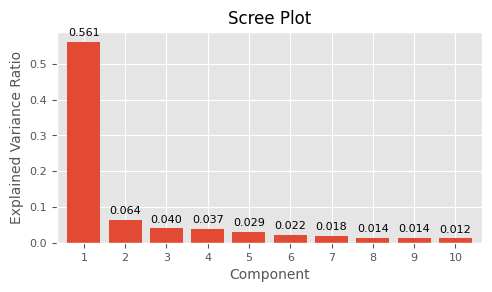

In [16]:
### Scree Plot
fig, ax = plt.subplots(1, 1, num=1, clear=True, figsize=(5,3))
k=10
plot_bar(Series(pca.explained_variance_ratio_[:k],
                index=np.arange(1, k+1)),
         ylabel='Explained Variance Ratio',
         xlabel="Component",
         legend=None,
         title='Scree Plot',
         ax=ax,
         fontsize=8,
         labels=[f"{i:.3f}" for i in pca.explained_variance_ratio_[:k]])
plt.tight_layout(pad=1)
plt.savefig(imgdir / 'explained.jpg')

__GMV portfolio volatility__

In [17]:
# Helper method to compute Minimum Variance Portfolio and realized volatility
def gmv(cov, ret):
    """Compute minimum variance portfolio and realized volatility"""
    w = np.linalg.inv(cov) @ np.ones((cov.shape[1], 1))
    return ret @ w/sum(w)

In [18]:
# Helper to compute EWMA covariance matrix estimate
def ewma(X, alpha=0.03, demean=False):
    weights = (1 - alpha)**np.arange(len(X))[::-1]
    if demean:
        X = X - X.mean(axis=0, keepdims=True)
    return (weights.reshape((1, -1)) * X.T) @ X / weights.sum()

In [19]:
# Rolling monthly evaluation
r = {}     # collect results of covariance matrix models
start_eval = 20000101
for retdate in tqdm(df.index[(df.index >= start_eval)]):
    x_train = Y[df.index < retdate, :]
    x_test = Y[df.index == retdate, :]
    keep = 5 * 12   # keep five years
    N = x_train.shape[1]
    r[retdate] = {}

    cov = EmpiricalCovariance().fit(x_train[-keep:, :]).covariance_
    
    r[retdate]['Full Covariance'] = float(gmv(cov, x_test))

    for alpha in [0.1, 0.06, 0.03, 0.01, 0.003]:
        r[retdate][f'EWMA({halflife(alpha=alpha):.0f}mo)'] = \
            float(gmv(ewma(x_train, alpha=alpha), x_test))

    r[retdate]['Eye'] = float(gmv(np.identity(x_train.shape[1]), x_test))

    r[retdate]['Diagonal'] = float(gmv(np.diagflat(np.diag(cov)), x_test))

    for k in [2, 5, 10, 15, 20]:
        r[retdate][f"PC 1-{k}"] = float(gmv(PCA(k).fit(x_train[-keep:, :])\
                                            .get_covariance(), x_test))

    r[retdate]['LW'] = float(gmv(LedoitWolf().fit(x_train[-keep:, :])\
                                 .covariance_, x_test))
    
    r[retdate]['OAS'] = float(gmv(OAS().fit(x_train[-keep:, :])\
                                  .covariance_, x_test))

100%|██████████| 282/282 [23:31<00:00,  5.00s/it]


In [20]:
ts = DataFrame.from_dict(r, orient='index')
vol = np.std(ts, axis=0)
show(vol, caption='Realized volatility of minimum variance portfolios')

,0
Realized volatility of minimum variance portfolios,
Full Covariance,0.0643
EWMA(7mo),0.0646
EWMA(11mo),0.0505
EWMA(23mo),0.0405
EWMA(69mo),0.0353
EWMA(231mo),0.0359
Eye,0.0486
Diagonal,0.0434
PC 1-2,0.0374


Plot evaluation period realized volatility of minimum variance portfolios

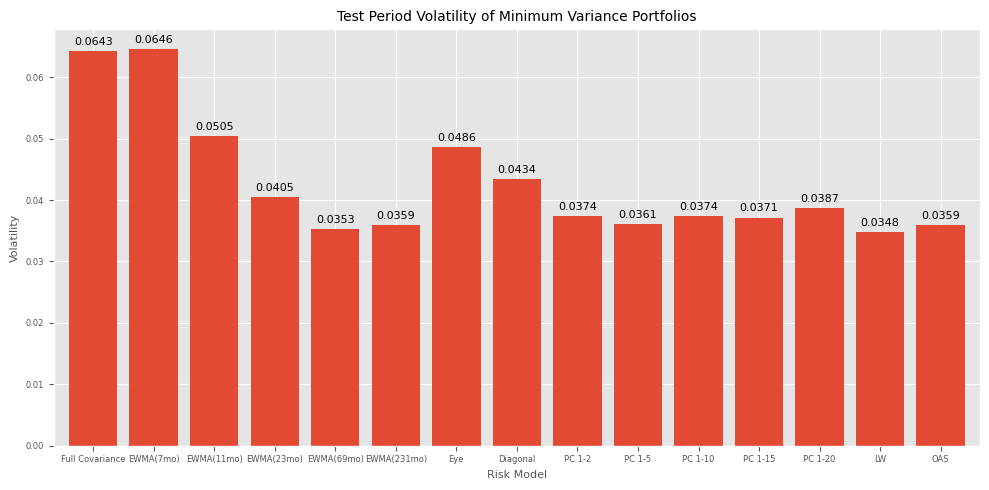

In [21]:
fig, ax = plt.subplots(1, 1, num=1, clear=True, figsize=(10, 5))
plot_bar(vol,
         ylabel='Volatility',
         xlabel='Risk Model',
         title='Test Period Volatility of Minimum Variance Portfolios',
         labels=[f"{v:.4f}" for v in vol],
         legend='',
         fontsize=6,
         ax=ax)
plt.tight_layout()
plt.savefig(imgdir / 'gmv.jpg')

Newey-west, Scholes Williams Beta
1/T \sum_t e_t^2 + 2/T \sum_L \sum_T w_l e_t e_t-l: w_l = 1-(l/(L+1))

Risk Decomposition: MCR, BL equilibrium, Risk Parity
u.T @ x = beta, since u is standardized (orthogonal) factor returns
u @ beta = stock's return due to orthogonal component
(u @ beta)*2 = variation of stock returns due to orthogonal component